In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from statsmodels.api import Logit

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


# 데이터 구성

In [4]:
df = pd.read_csv("HMEQ.csv", engine='python')
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


# 데이터 전처리 - 결측치 처리

In [7]:
df.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [8]:
df['JOB'].fillna('Other', inplace=True)
df.fillna(df.mean(), inplace=True)

In [10]:
df.isnull().sum(axis=0)

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

# 데이터 전처리 - 데이터분할

In [12]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1234)
print("train : ", df_train.shape)
print("test : ", df_test.shape)

train :  (2623, 13)
test :  (1125, 13)


# step3 모델 및 회귀계수 검토

In [14]:
log_model = Logit.from_formula("BAD~LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ + DEROG + \
                                DELINQ + CLAGE + NINQ + CLNO + DEBTINC", df_train)
log_result = log_model.fit()
print(log_result.summary())


Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Mon, 10 Feb 2020   Pseudo R-squ.:                  0.2257
Time:                        12:01:39   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997

# step4 예측 및 성능평가

In [17]:
y_pred = log_result.predict(df_test)
y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class.head()

print("Accuracy :", accuracy_score(df_test['BAD'], y_pred_class))
print("Confusion matrix :\n", confusion_matrix(df_test['BAD'], y_pred_class))


Accuracy : 0.9244444444444444
Confusion matrix :
 [[1017    4]
 [  81   23]]


# 결론 도출 - 최종회귀식

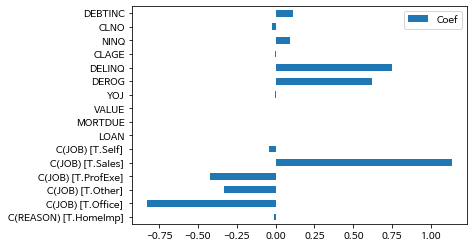

In [23]:
df_logistic_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y="Coef")

# 결론 도출 - 표준화 회귀 계수

In [27]:
df_char = df.select_dtypes(include = "object")
df_numeric = df.select_dtypes(exclude = "object")

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)

df_scaled = pd.concat([df_numeric_scaled, df_char], axis=1)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,3.140664,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,3.140664,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,-0.318404,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,3.140664,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,-0.318404,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [28]:
df_scaled['BAD'] = np.where(df_scaled['BAD'] >0,1,0)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,0,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,1,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,0,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [30]:
df_scaled_train, df_scaled_test = train_test_split(df_scaled, test_size=3, random_state=1234)


In [32]:

scaled_log_model = Logit.from_formula("BAD~LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ + DEROG + \
                                DELINQ + CLAGE + NINQ + CLNO + DEBTINC", df_scaled_train)

scaled_log_result = scaled_log_model.fit()
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.240373
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 3745
Model:                          Logit   Df Residuals:                     3728
Method:                           MLE   Df Model:                           16
Date:                Mon, 10 Feb 2020   Pseudo R-squ.:                  0.2165
Time:                        14:00:07   Log-Likelihood:                -900.20
converged:                       True   LL-Null:                       -1149.0
Covariance Type:            nonrobust   LLR p-value:                 1.060e-95
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.5850      0.176    -14.660      0.000      -2.931      -2.239

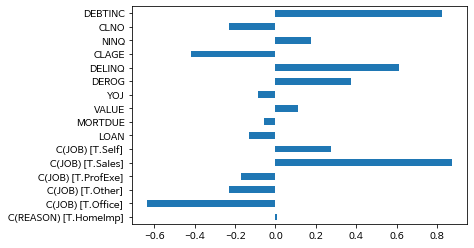

In [33]:
df_log_scaled_coef = pd.DataFrame({"Coef": scaled_log_result.params.values[1:]}, index = scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y="Coef", legend=False)

# 로지스틱 회귀분석 실습

In [32]:
df = pd.read_csv("통신고객이탈.csv", engine='python')
df

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,Churned,K413330,M,19,Play 100,SOP10,Med,17.40,12,60,100.8,27,59.4,127,628.2
926,Churned,K413410,F,59,Play 100,SOP20,Med,17.37,15,82,130.2,12,25.8,357,650.7
927,Churned,K415490,F,33,Play 300,S50,Med,44.93,12,174,286.2,25,67.0,596,1039.0
928,Churned,K415880,F,25,Play 300,S50,Med,40.43,14,315,552.0,0,0.0,609,1188.3


In [33]:
df.isnull().sum()


CHURN                 0
CUSTOMER_ID           0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
dtype: int64

In [34]:
df['CHURN'] = np.where(df['CHURN'] == 'Active', 0, 1)
df

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,0,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,0,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,0,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,0,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,0,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,1,K413330,M,19,Play 100,SOP10,Med,17.40,12,60,100.8,27,59.4,127,628.2
926,1,K413410,F,59,Play 100,SOP20,Med,17.37,15,82,130.2,12,25.8,357,650.7
927,1,K415490,F,33,Play 300,S50,Med,44.93,12,174,286.2,25,67.0,596,1039.0
928,1,K415880,F,25,Play 300,S50,Med,40.43,14,315,552.0,0,0.0,609,1188.3


In [35]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1234)
print("train : ", df_train.shape)
print("test : ", df_test.shape)

train :  (651, 15)
test :  (279, 15)


In [37]:
log_model = Logit.from_formula("""CHURN~C(GENDER) + AGE + C(CHARGE_TYPE) + C(HANDSET) + C(USAGE_BAND)
                                + SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME +
                                WEEKEND_CALLS_NO + WEEKEND_CALLS_TIME + TOTAL_CALLS_NO + TOTAL_CALLS_TIME""", df_train)
log_result = log_model.fit()
print(log_result.summary())

         Current function value: 0.253230
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  651
Model:                          Logit   Df Residuals:                      621
Method:                           MLE   Df Model:                           29
Date:                Mon, 10 Feb 2020   Pseudo R-squ.:                  0.5059
Time:                        14:15:36   Log-Likelihood:                -164.85
converged:                      False   LL-Null:                       -333.64
Covariance Type:            nonrobust   LLR p-value:                 2.736e-54
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -24.1056   2065.436     -0.012      0.991   -4072.286    4024.075
C(GENDER)[T.M]   

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [38]:
y_pred = log_result.predict(df_test)
y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class.head()

print("Accuracy :", accuracy_score(df_test['CHURN'], y_pred_class))
print("Confusion matrix :\n", confusion_matrix(df_test['CHURN'], y_pred_class))


Accuracy : 0.9139784946236559
Confusion matrix :
 [[227   8]
 [ 16  28]]


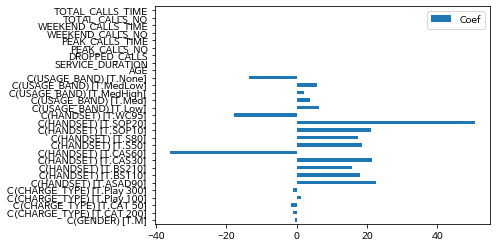

In [39]:
df_logistic_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y="Coef")

In [40]:
df_char = df.select_dtypes(include = "object")
df_numeric = df.select_dtypes(exclude = "object")

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)

df_scaled = pd.concat([df_numeric_scaled, df_char], axis=1)
df_scaled.head()

,CHURN,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,CUSTOMER_ID,GENDER,CHARGE_TYPE,HANDSET,USAGE_BAND
0,-0.489898,-0.030604,-0.069958,0.949112,-0.032834,-0.617357,-0.432263,-0.755024,0.079015,-0.783880,K102990,F,CAT 100,ASAD170,Med
1,-0.489898,-0.335827,-0.243451,2.091732,0.651830,-0.080674,-0.307456,-0.579614,0.259163,-0.458260,K103280,M,CAT 100,S50,Med
2,-0.489898,-0.335827,1.063386,2.377387,0.152687,-0.225031,-0.993897,-1.347031,-0.325316,-0.817357,K103660,M,CAT 100,ASAD170,Med
3,-0.489898,2.258568,1.006966,-0.479163,0.302872,-0.070196,-0.120245,1.434855,-0.081116,-0.396795,K103730,M,CAT 100,ASAD170,Med
4,-0.489898,1.571816,1.530970,-0.764818,-0.019583,-0.276254,-0.557071,-0.661838,-0.289287,-0.709610,K104560,F,CAT 100,S50,Med


In [41]:
df_scaled['CHURN'] = np.where(df_scaled['CHURN'] >0,1,0)
df_scaled.head()

,CHURN,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,CUSTOMER_ID,GENDER,CHARGE_TYPE,HANDSET,USAGE_BAND
0,0,-0.030604,-0.069958,0.949112,-0.032834,-0.617357,-0.432263,-0.755024,0.079015,-0.783880,K102990,F,CAT 100,ASAD170,Med
1,0,-0.335827,-0.243451,2.091732,0.651830,-0.080674,-0.307456,-0.579614,0.259163,-0.458260,K103280,M,CAT 100,S50,Med
2,0,-0.335827,1.063386,2.377387,0.152687,-0.225031,-0.993897,-1.347031,-0.325316,-0.817357,K103660,M,CAT 100,ASAD170,Med
3,0,2.258568,1.006966,-0.479163,0.302872,-0.070196,-0.120245,1.434855,-0.081116,-0.396795,K103730,M,CAT 100,ASAD170,Med
4,0,1.571816,1.530970,-0.764818,-0.019583,-0.276254,-0.557071,-0.661838,-0.289287,-0.709610,K104560,F,CAT 100,S50,Med


In [42]:
df_scaled_train, df_scaled_test = train_test_split(df_scaled, test_size=0.3, random_state=1234)

scaled_log_model = Logit.from_formula("""CHURN~C(GENDER) + AGE + C(CHARGE_TYPE) + C(HANDSET) + C(USAGE_BAND)
                                + SERVICE_DURATION + DROPPED_CALLS + PEAK_CALLS_NO + PEAK_CALLS_TIME +
                                WEEKEND_CALLS_NO + WEEKEND_CALLS_TIME + TOTAL_CALLS_NO + TOTAL_CALLS_TIME""", df_scaled_train)

scaled_log_result = scaled_log_model.fit()
print(scaled_log_result.summary())

         Current function value: 0.253230
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  651
Model:                          Logit   Df Residuals:                      621
Method:                           MLE   Df Model:                           29
Date:                Mon, 10 Feb 2020   Pseudo R-squ.:                  0.5059
Time:                        14:19:44   Log-Likelihood:                -164.85
converged:                      False   LL-Null:                       -333.64
Covariance Type:            nonrobust   LLR p-value:                 2.736e-54
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -22.6857   2065.401     -0.011      0.991   -4070.798    4025.427
C(GENDER)[T.M]   

/home/pirl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


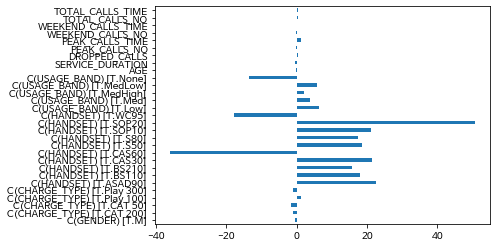

In [43]:
df_log_scaled_coef = pd.DataFrame({"Coef": scaled_log_result.params.values[1:]}, index = scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y="Coef", legend=False)